## **Fig2k,l** ##
**One can compute Eigengene and Hotspot in this notebook or read a prepared one**

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv
import numpy as np

In [8]:
data_name = 'DG_bin_ppt'
# data_name = ''
[k_nei, K, L] = [10, 2, 10]
result_path = 'main_results/'+data_name+' '+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

adata0 = sc.read_h5ad('data/'+data_name+'.h5ad')
adata = adata0.copy()

In [9]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

In [10]:
adata

AnnData object with n_obs × n_vars = 3139 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'palantir_pseudotime', 'palantir_entropy'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'ClusterName_colors', 'DM_EigenValues', 'neighbors', 'palantir_waypoints', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'DM_EigenVectors', 'DM_EigenVecto

## **Data Visualization** 

In [11]:
# cmap = plt.colormaps['Spectral']
# fig = sc.pl.embedding(
#     adata,
#     color=['crc', "Cell_type"],
#     basis="umap",
#     color_map=cmap,
#     return_fig=True
# )
# fig.savefig(result_path+'output_umap.png')

## **Preprocessing**

In [12]:
from scipy.sparse import csr_matrix

sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)
scv.tl.velocity(adata)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
Xs = adata.layers['Ms'] #adata.X.A#
# Xs = adata.layers['M_s'] #如果是EG_ab_dyn
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])
cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei-1])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

In [14]:
X_umap = adata.obsm['X_umap']
X_plt = -X_pca[:,0]
Y_plt = -X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min
Y_ori = Y_min

## **CRC**

In [15]:
from utils import *
from g2g_model_Fisher import *

In [16]:
# epochs = 400
# nsamples = 5
# learning_rate = 1e-3
# seed = 0
# # n_workers = 4

# if seed is not None:
#     reset_seeds(seed)

# A = A_mat
# A = A.astype(np.float32)
# X = Xs.astype(np.float32)
# z = np.zeros(adata.n_obs)

# n = A.shape[0]
# train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
# A_train = A[train_nodes, :][:, train_nodes]
# X_train = X[train_nodes]
# z_train = z[train_nodes]
# A_val = A[val_nodes, :][:, val_nodes]
# X_val = X[val_nodes]
# z_val = z[val_nodes]

# train_data = AttributedGraph(A_train, X_train, z_train, K)
# val_data = AttributedGraph(A_val, X_val, z_val, K)

# encoder = Encoder(X.shape[1], L)

In [17]:
# optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

# iterations = epochs #// n_workers
# dataset = GraphDataset(train_data, nsamples, iterations)
# loader = DataLoader(
#     dataset,
#     batch_size=1,
# #     num_workers=n_workers,
#     worker_init_fn=reset_seeds,
#     collate_fn=lambda args: args,
# )

In [18]:
# for batch_idx, data in enumerate(loader):
#     encoder.train()
#     optimizer.zero_grad()

#     # compute weighted loss
#     _ ,i,j,k,w,nsamples = data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5]

#     mu, sigma = encoder.forward(data[0][0])

#     mu_i = gather_rows(mu, i)
#     sigma_i = gather_rows(sigma, i)
#     mu_j = gather_rows(mu, j)
#     sigma_j = gather_rows(sigma, j)
#     mu_k = gather_rows(mu, k)
#     sigma_k = gather_rows(sigma, k)

#     diff_ij = mu_i - mu_j
#     ss_ij = sigma_i + sigma_j
#     ds_ij = sigma_i - sigma_j
    
#     closer = 2*((torch.log (
        
#         (torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)+torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)/\
#         torch.abs((torch.sqrt(0.5*diff_ij**2+ss_ij**2+1e-10)-torch.sqrt(0.5*diff_ij**2+ds_ij**2+1e-10)+1e-10)
#         +1e-10)
#             ))**2).sum(axis=-1)

#     diff_ik = mu_i - mu_k
#     ss_ik = sigma_i + sigma_k
#     ds_ik = sigma_i - sigma_k
    
#     apart = 2*((torch.log (
        
#         (torch.sqrt(0.5*diff_ik**2+ss_ik**2+1e-10)+torch.sqrt(0.5*diff_ik**2+ds_ik**2+1e-10)+1e-10)/\
#         torch.abs((torch.sqrt(0.5*diff_ik**2+ss_ik**2+1e-10)-torch.sqrt(0.5*diff_ik**2+ds_ik**2+1e-10)+1e-10)
#         +1e-10)
#             ))**2).sum(axis=-1)

#     # E = closer*weight[i,j] + torch.exp(-torch.sqrt(apart))*weight[i,k] 
#     E = closer + torch.exp(-torch.sqrt(apart)) 

#     loss = E.dot(w) / nsamples
#     if batch_idx% 10 == 0:
#         print(batch_idx,loss)
#     loss.backward()
#     optimizer.step()

# torch.save(encoder,result_path+'encoder.pt')

In [19]:
encoder = torch.load(result_path+'encoder.pt')

mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

In [20]:
cRc_arr=[]
cRc_arr_eu=[]
A = A_mat
A = csr_matrix(A + np.eye(A.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

In [21]:
if data_name == 'zebrafish_dynamo_part':    
    adata.obs['crc_smooth'] = crc_smooth
    fig = sc.pl.embedding(
        adata,
        color=['crc_smooth', "Cell_type"],
        basis="umap",
        color_map=cmap,
        return_fig=True
    )
    fig.savefig(result_path+'sc_crc_umap.png')

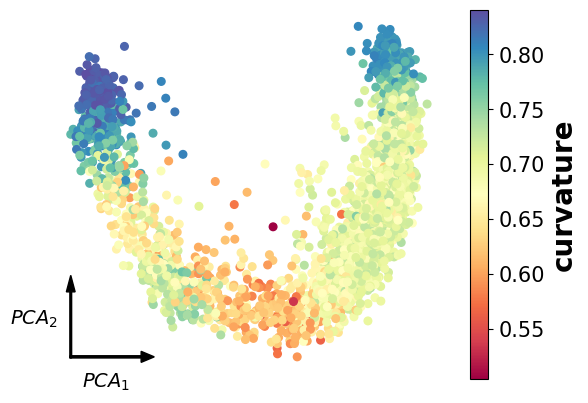

In [22]:
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+'crc_smooth')
plt.show()


In [23]:
np.save(result_path+'/crc_smooth', crc_smooth)

In [24]:
adata

AnnData object with n_obs × n_vars = 3139 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'palantir_pseudotime', 'palantir_entropy'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'ClusterName_colors', 'DM_EigenValues', 'neighbors', 'palantir_waypoints', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'DM_EigenVectors', 'DM_EigenVecto

## 

## **IV**

**velo_pca**

In [25]:
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = velo_g@adata.varm['PCs']

In [26]:
#------use a simple neural network to study dmu/dt and dsigma/dt
latent_z = np.hstack((mu_learned,sigma_learned))
pca_dim = 50
learning_rate = 1e-3

model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    if epoch% 10 == 9:
        print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()

Z_velo = np.array([pZ_pX[i]@velo_pca[i] for i in range(X.shape[0])])

zv2 = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    for j in range(L):
        # zv2[i] += Fisher_g[i,2*j,2*j]*Z_velo[i,2*j]**2 + Fisher_g[i,2*j+1,2*j+1]*Z_velo[i,2*j+1]**2
        zv2[i] += Fisher_g[i,j,j]*Z_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*Z_velo[i,L+j]**2
zv1 = np.sqrt(zv2)
zv1_smooth = smooth_func(zv1)

9 tensor(108.8981, grad_fn=<MseLossBackward0>)
19 tensor(101.2865, grad_fn=<MseLossBackward0>)
29 tensor(87.3301, grad_fn=<MseLossBackward0>)
39 tensor(66.1910, grad_fn=<MseLossBackward0>)
49 tensor(41.8982, grad_fn=<MseLossBackward0>)
59 tensor(22.4248, grad_fn=<MseLossBackward0>)
69 tensor(13.4247, grad_fn=<MseLossBackward0>)
79 tensor(9.9772, grad_fn=<MseLossBackward0>)
89 tensor(6.9411, grad_fn=<MseLossBackward0>)
99 tensor(4.6486, grad_fn=<MseLossBackward0>)
109 tensor(3.0083, grad_fn=<MseLossBackward0>)
119 tensor(1.9576, grad_fn=<MseLossBackward0>)
129 tensor(1.3582, grad_fn=<MseLossBackward0>)
139 tensor(1.0176, grad_fn=<MseLossBackward0>)
149 tensor(0.8343, grad_fn=<MseLossBackward0>)
159 tensor(0.7354, grad_fn=<MseLossBackward0>)
169 tensor(0.6728, grad_fn=<MseLossBackward0>)
179 tensor(0.6252, grad_fn=<MseLossBackward0>)
189 tensor(0.5863, grad_fn=<MseLossBackward0>)
199 tensor(0.5534, grad_fn=<MseLossBackward0>)
209 tensor(0.5252, grad_fn=<MseLossBackward0>)
219 tensor(0.50

In [27]:
adata.obs['IV_pca'] = zv1_smooth

In [28]:
if data_name == 'zebrafish_dynamo_part':
    adata.obs['crc_smooth'] = crc_smooth
    fig = sc.pl.embedding(
        adata,
        color=['crc_smooth', 'IV_pca', "Cell_type"],
        basis="umap",
        color_map=cmap,
        return_fig=True
    )

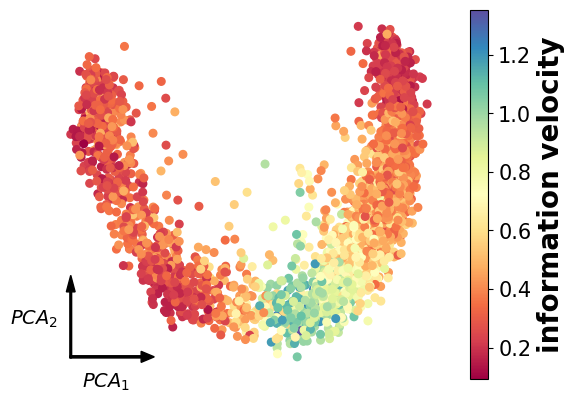

In [29]:
idx = ~np.isnan(zv1_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=zv1_smooth[idx],s=30,cmap=cmap)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel('information velocity',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# plt.savefig(figure_path+'5c1.png',dpi=600,bbox_inches='tight')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+'iv_smooth')
plt.show()

In [30]:
np.save(result_path+'/iv_smooth', zv1_smooth)

## **Fisher**

In [31]:
eigs = np.zeros((X.shape[0],2*L))
eigvecs = np.zeros((X.shape[0],2*L, 2*L))
for i in range(X.shape[0]):
    eig, eigvec = np.linalg.eig(Fisher_g[i])
    sorted_indices = np.argsort(eig)[::-1]  # 从大到小排序
    eigs[i] = eig[sorted_indices]
    eigvecs[i] = eigvec[sorted_indices]

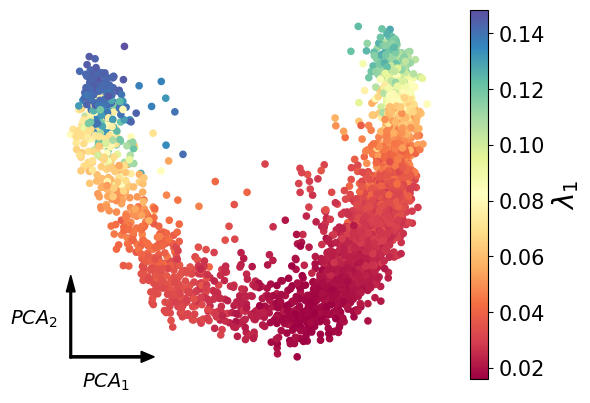

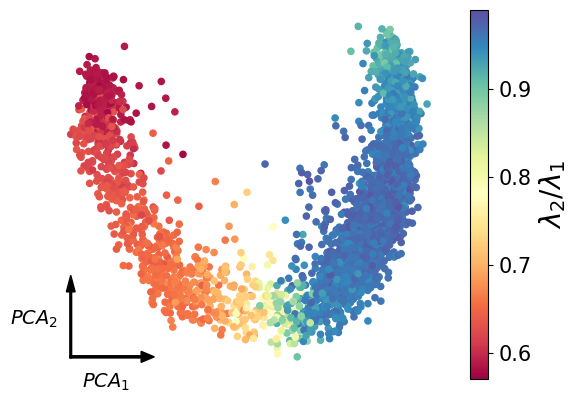

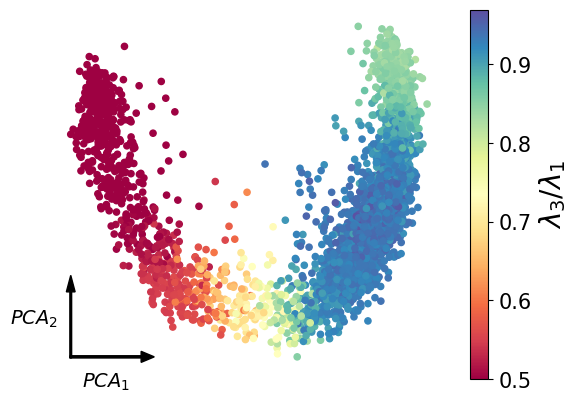

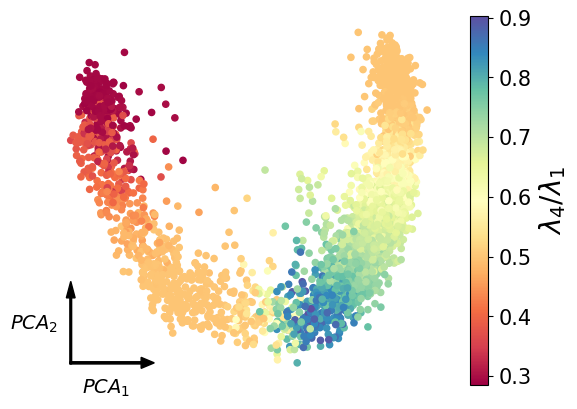

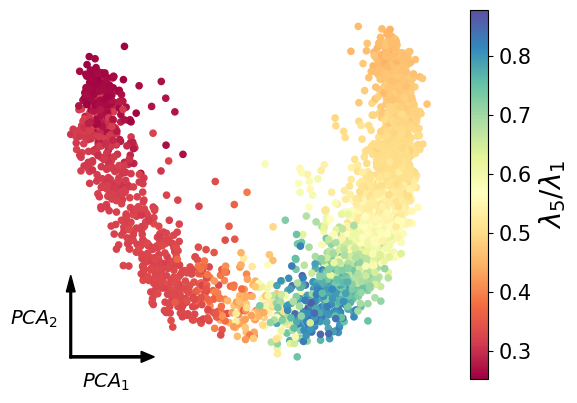

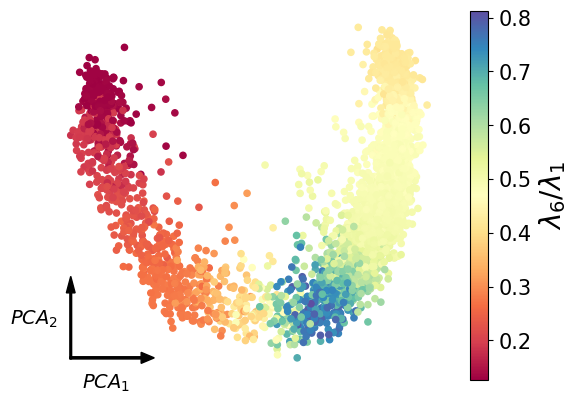

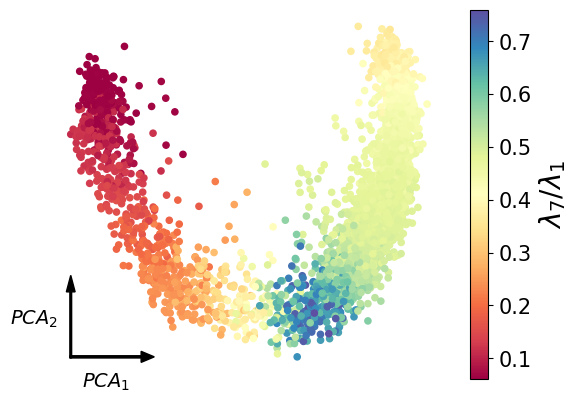

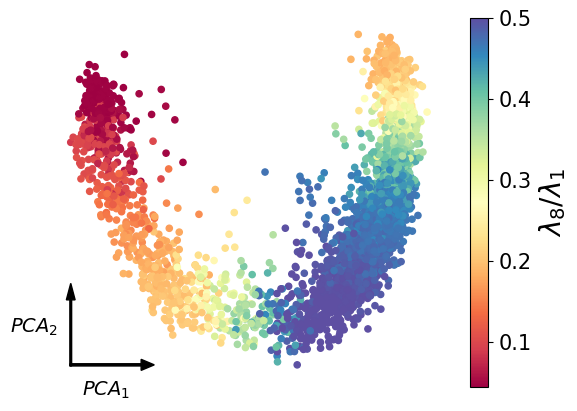

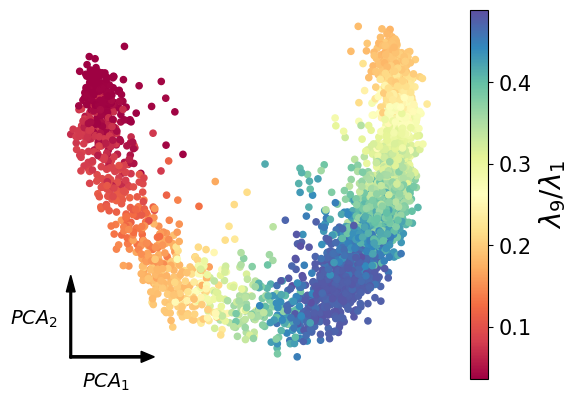

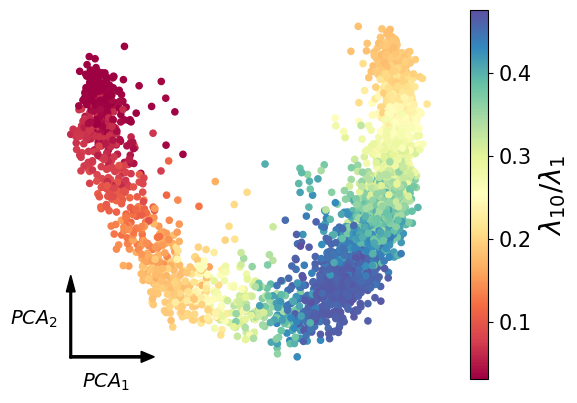

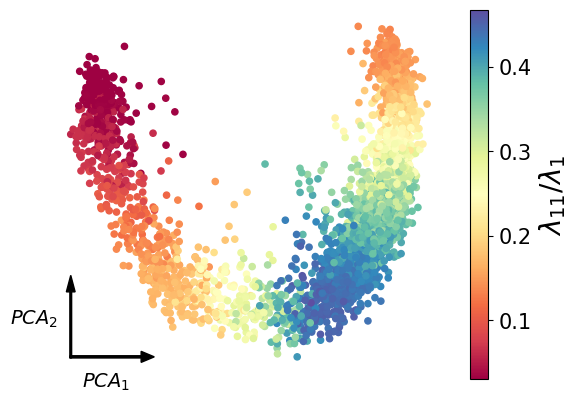

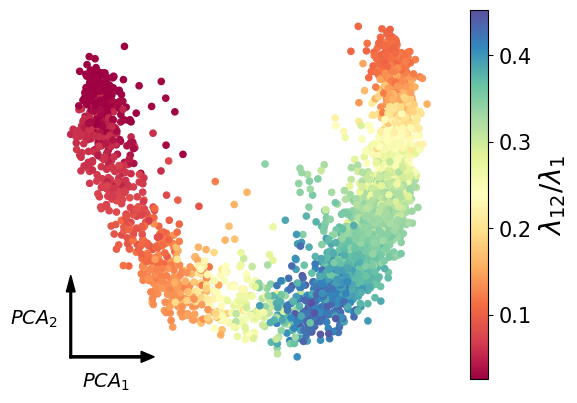

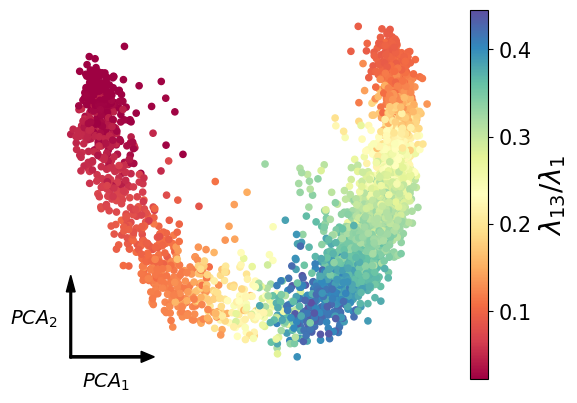

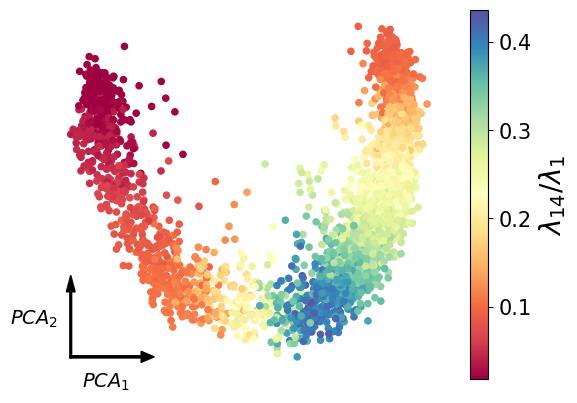

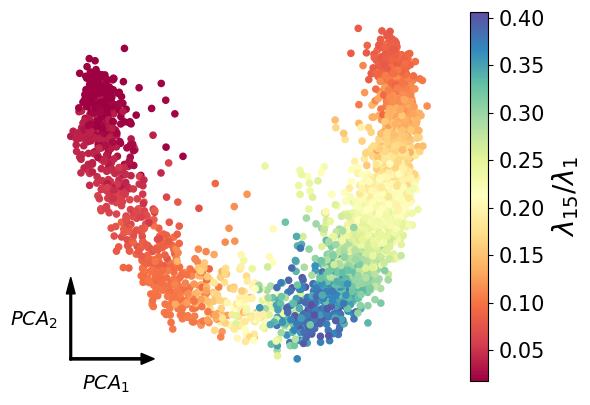

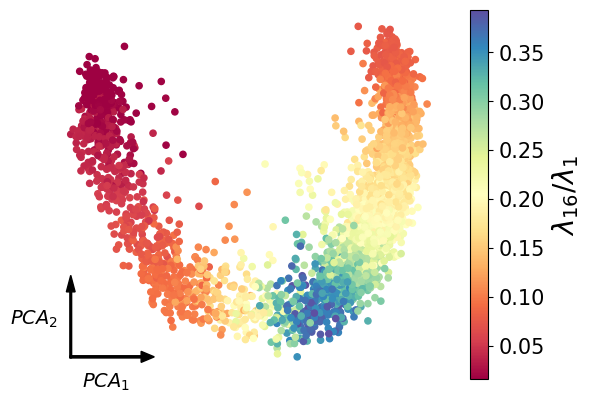

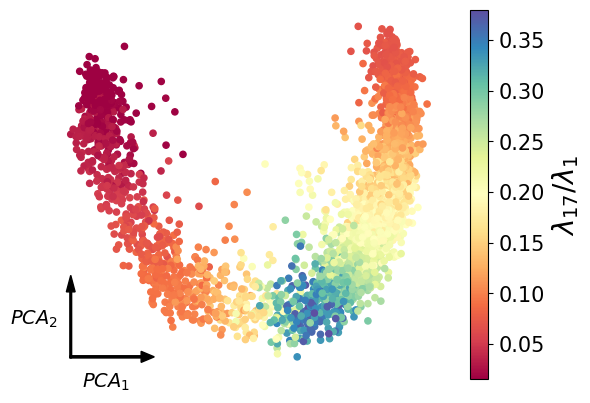

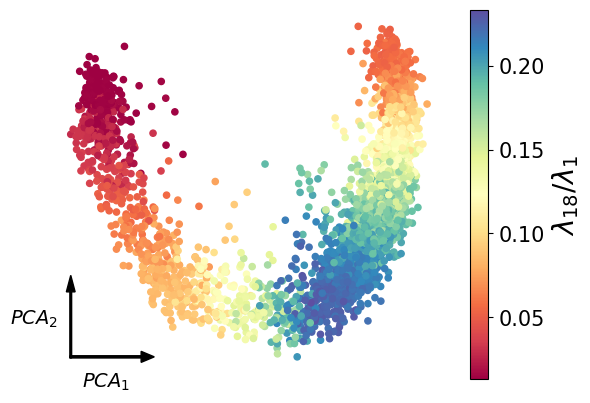

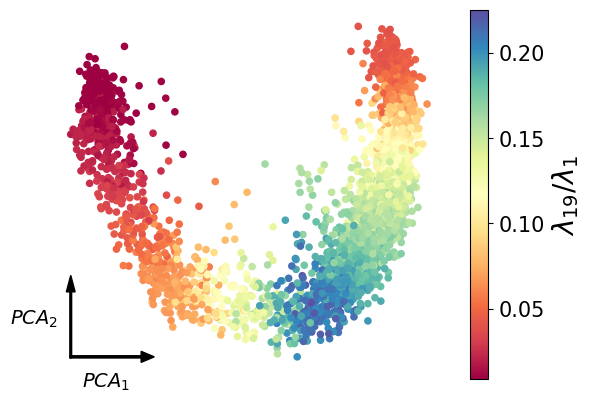

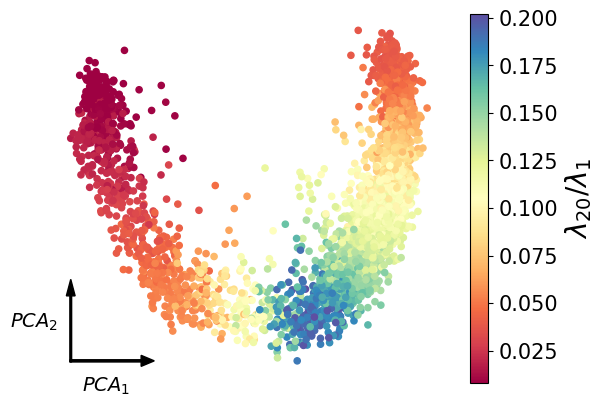

In [32]:
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs[:,0]), cmap=cmap, s=20)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel(f'$\lambda_{1}$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+f'eig_latent_{1}')
plt.show()

for k in range(1,2*L):
    cmap = plt.colormaps['Spectral']
    plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs[:,k]/eigs[:,0]), cmap=cmap, s=20)
    plt.axis('off')

    clb=plt.colorbar()
    clb.ax.set_ylabel(rf'$\lambda_{{{k+1}}}/\lambda_{1}$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)

    plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
    plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
    plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
    plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

    plt.savefig(result_path+f'eig_ratio_latent_{k+1}')
    plt.show()

In [33]:
np.save(result_path+'/fisher_latent', Fisher_g)
np.save(result_path+'/eig_latent', eigs)
np.save(result_path+'/eigvec_latent', eigvecs)

## **Fisher pca**

In [34]:
Fisher_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    Fisher_pca[i] = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]

In [35]:
eigs_pca = np.zeros((X.shape[0],pca_dim))
eigvecs_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    eig, eigvec = np.linalg.eig(Fisher_pca[i])
    sorted_indices = np.argsort(eig)[::-1]  # 从大到小排序
    eigs_pca[i] = eig[sorted_indices]
    eigvecs_pca[i] = eigvec[sorted_indices]

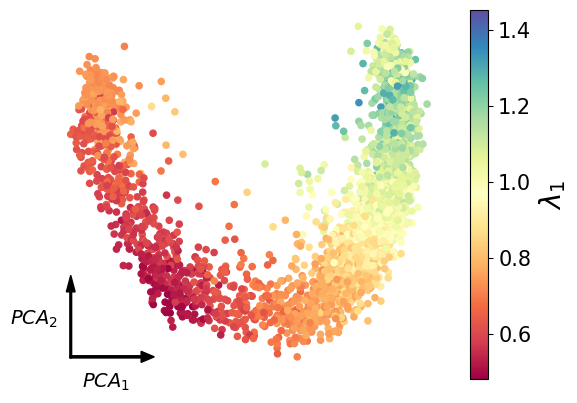

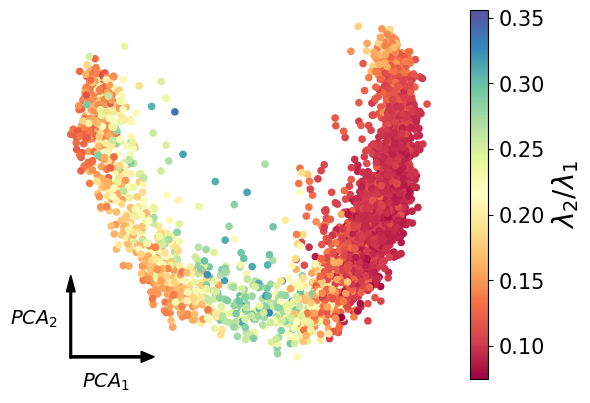

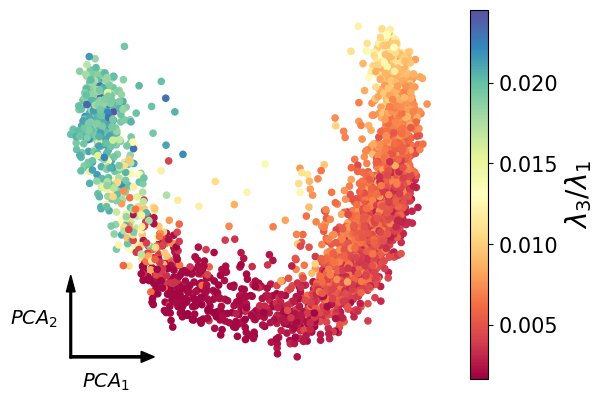

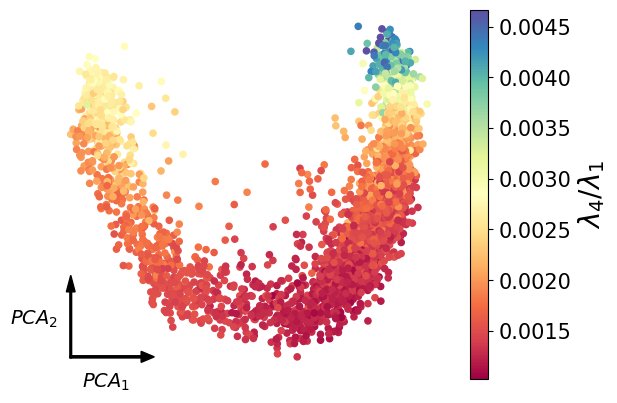

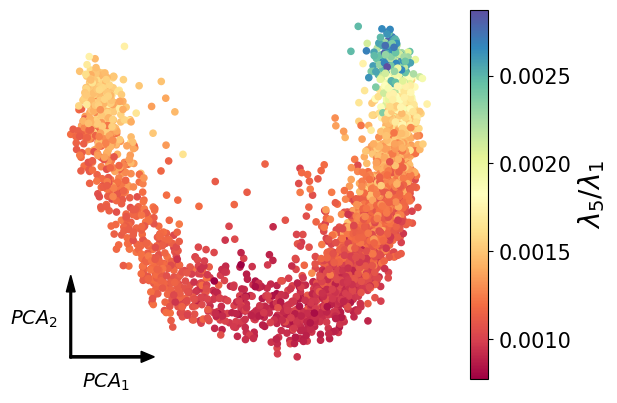

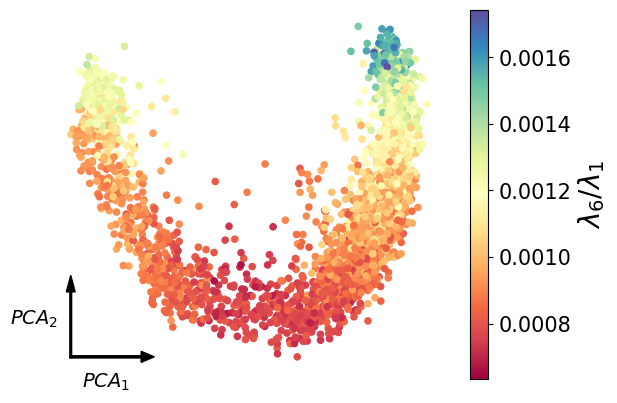

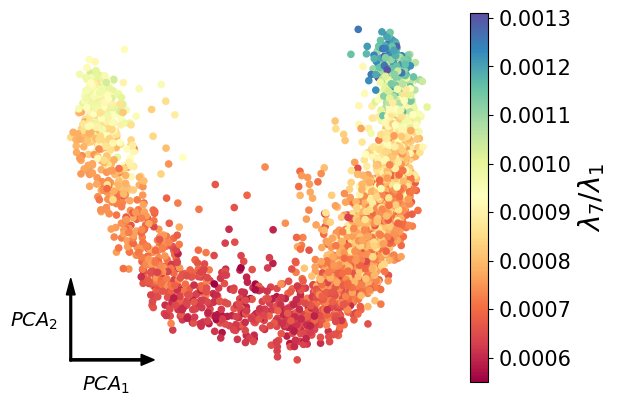

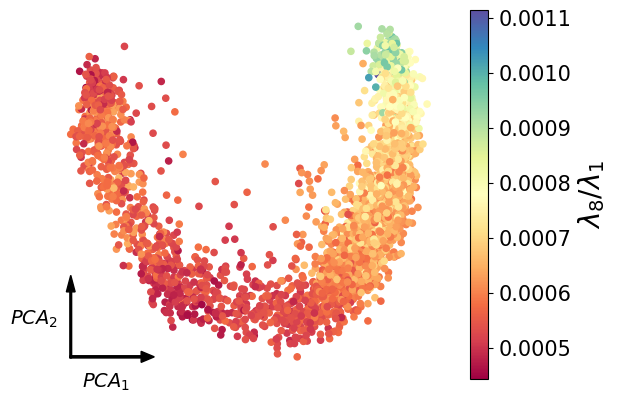

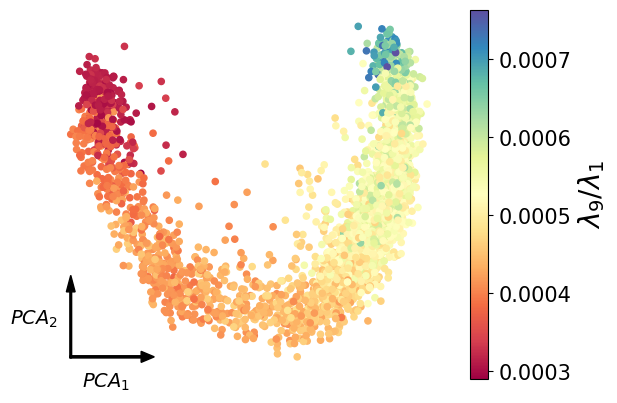

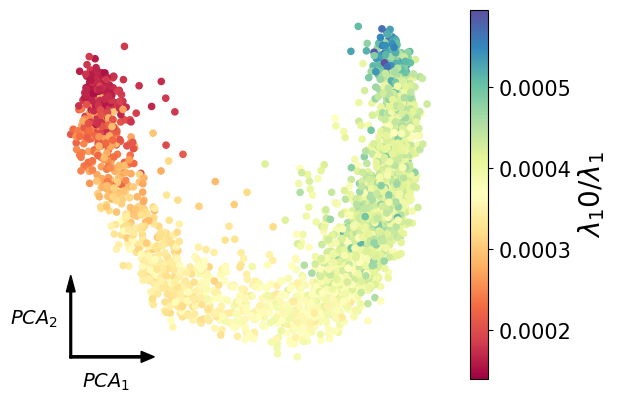

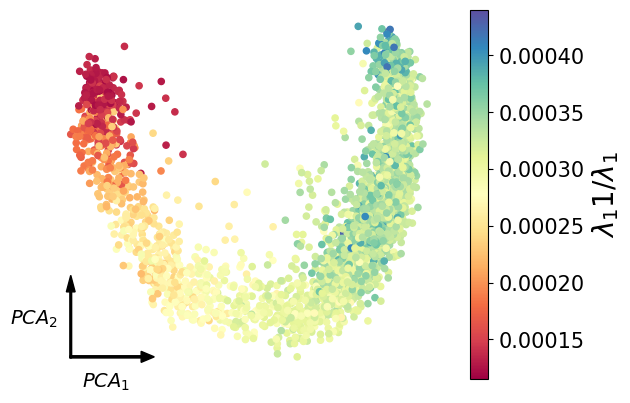

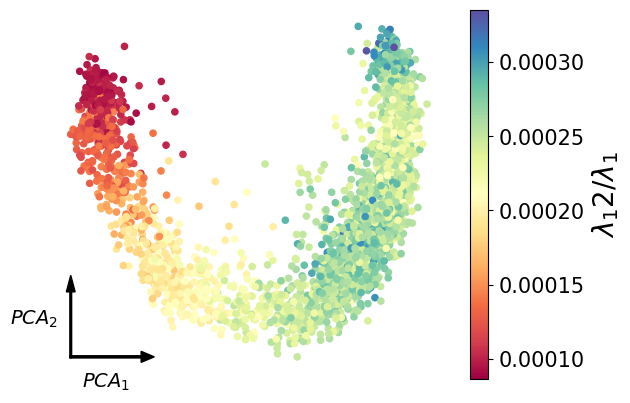

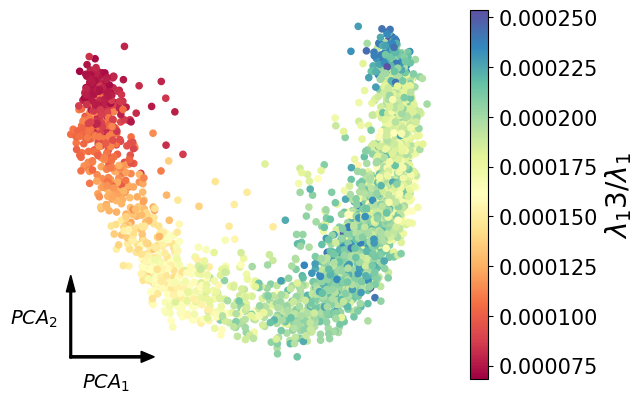

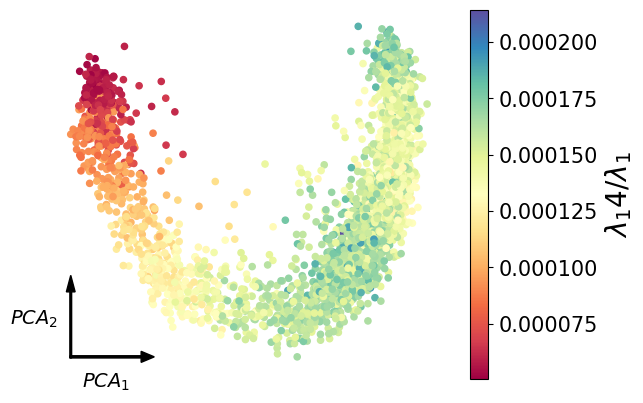

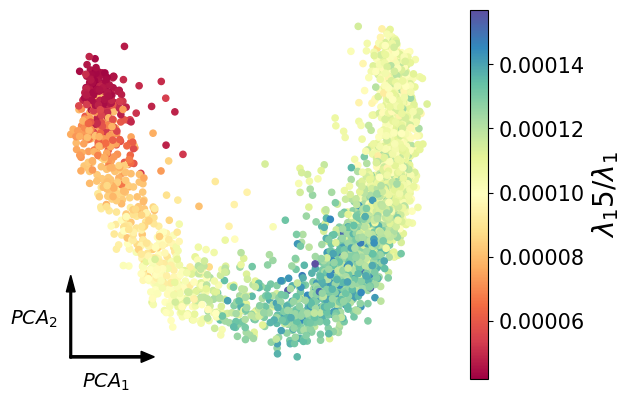

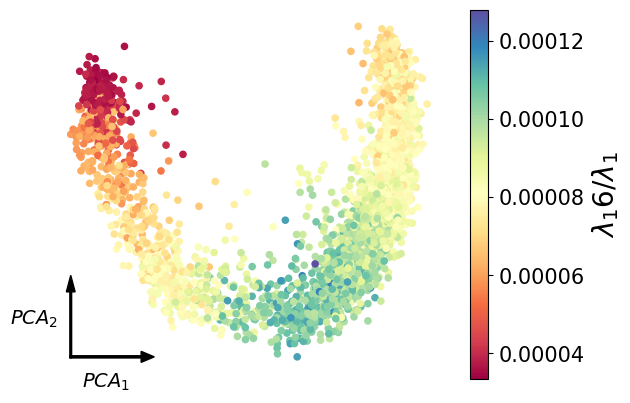

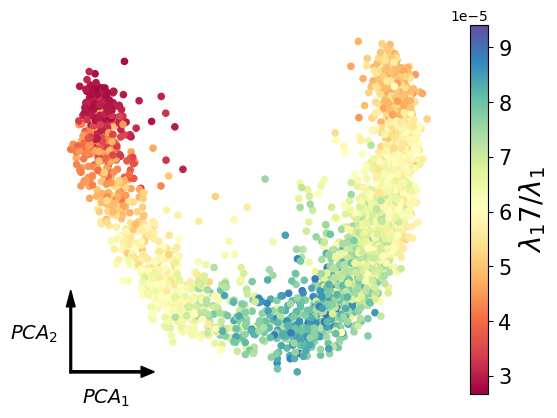

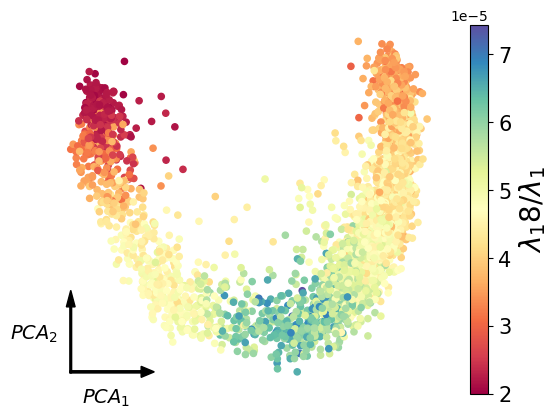

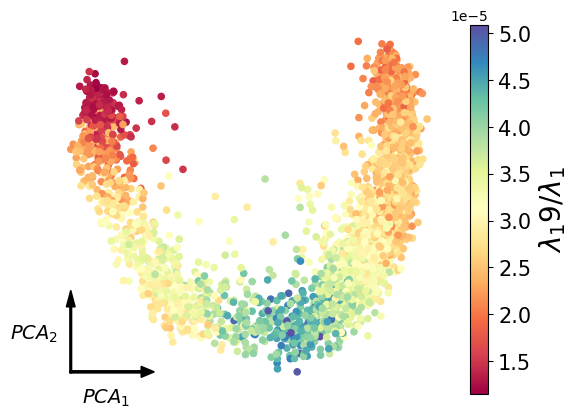

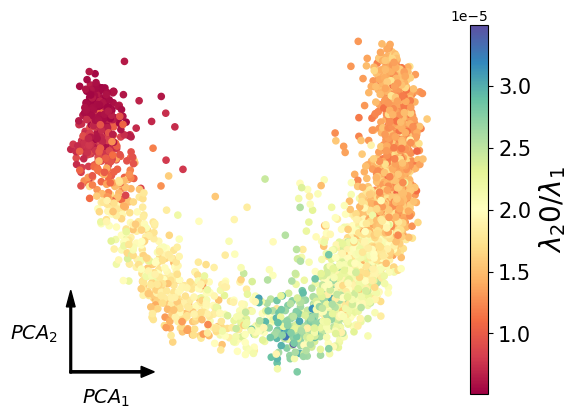

In [36]:
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs_pca[:,0]), cmap=cmap, s=20)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel(f'$\lambda_{1}$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+f'eig_pca_{1}')
plt.show()

for k in range(1,20):
    cmap = plt.colormaps['Spectral']
    plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs_pca[:,k]/eigs_pca[:,0]), cmap=cmap, s=20)
    plt.axis('off')

    clb=plt.colorbar()
    clb.ax.set_ylabel(f'$\lambda_{k+1}/\lambda_{1}$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)

    plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
    plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
    plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
    plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

    plt.savefig(result_path+f'eig_ratio_pca_{k+1}')
    plt.show()

In [37]:
np.save(result_path+'/fisher_pca', Fisher_pca)
np.save(result_path+'/eig_pca', eigs_pca)
np.save(result_path+'/eigvec_pca', eigvecs_pca)

## **Eigen gene**

In [38]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage

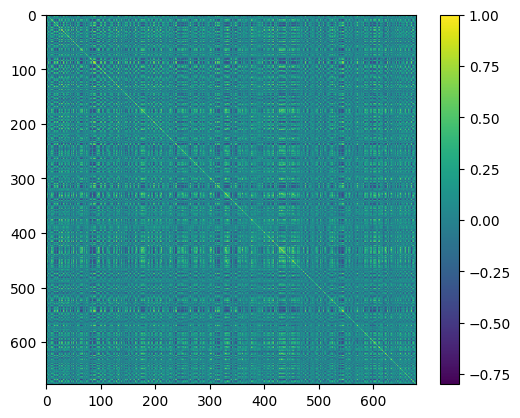

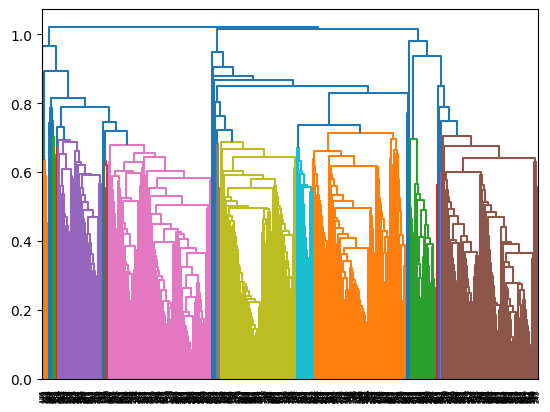

In [39]:
scaler=StandardScaler()
X=scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()

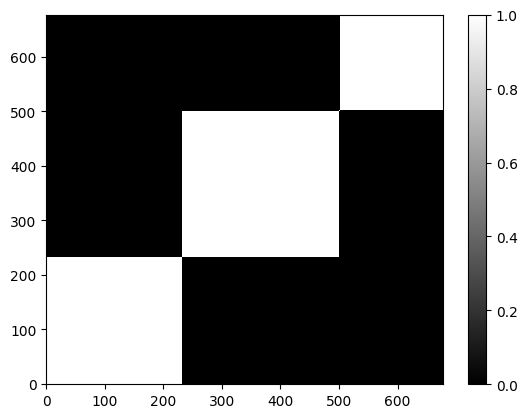

In [40]:
td = 0.98
T = fcluster(Z, t=td, criterion='distance')
# T=fcluster(Z, t=td, criterion='maxclust')
T_re = T[dg['leaves']]

X_corr_label = np.zeros(X_corr_re.shape)
for i in range(X_corr_re.shape[0]):
    label_ind = np.where(T_re==T_re[i])[0]
    X_corr_label[i,label_ind] = 1

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()

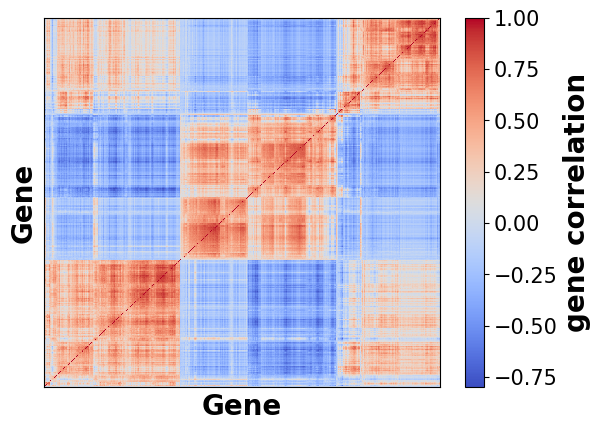

In [41]:
# plt.figure(figsize=(9,6))
plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
# plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')

plt.xlabel('Gene',fontsize=20,fontweight='bold')
plt.ylabel('Gene',fontsize=20,fontweight='bold')
plt.xticks([])
plt.yticks([])
# plt.xticks(fontsize=15)#,fontweight='bold')
# plt.yticks(fontsize=15)#,fontweight='bold')

clb = plt.colorbar()
clb.ax.set_ylabel('gene correlation',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

# alphas = X_corr_label.copy()
# alphas[X_corr_label==1] = 0
# alphas[X_corr_label==0] = 0.5
# plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower',alpha=alphas)

# plt.savefig(result_path+'3f.png',dpi=600,bbox_inches='tight')
plt.show()

In [42]:
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w=[]
    for i in np.unique(T_re):
        if i == -1:
            continue
        if (X_re[:,T_re==i]).shape[1] <= 1:
            continue

        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return eigen_X_w

In [43]:
eigen_X_w = eigen_gene(X_re,T_re)
eigen_dim=len(eigen_X_w)
print(eigen_dim)

[0.45576048 0.08021189]
[0.42471874 0.13492687]
[0.4677814  0.11091509]
3


In [44]:
cell_eigen_X=np.zeros((X_re.shape[0],eigen_dim))
for j in range(X_re.shape[0]):
    for k in range(len(eigen_X_w)):
        cell_eigen_X[j,k]=np.dot(eigen_X_w[k],X_re[j,T_re==k+1])

In [45]:
model = nn.Sequential(
    nn.Linear(cell_eigen_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

x_in=torch.tensor(cell_eigen_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_pEg = np.zeros([cell_eigen_X.shape[0], L*2, cell_eigen_X.shape[1]])

# Compute the gradients
for i in range(cell_eigen_X.shape[0]):
    x0=torch.tensor(cell_eigen_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pEg[i,j,:] = x0.grad.detach()
print(pZ_pEg.shape)

(3139, 20, 3)


In [46]:
Fisher_eg = np.zeros((X.shape[0],eigen_dim, eigen_dim))
for i in range(X.shape[0]):
    Fisher_eg[i] = pZ_pEg[i].T@Fisher_g[i]@pZ_pEg[i]

In [47]:
eigs_eg = np.zeros((X.shape[0],eigen_dim))
eigvecs_eg = np.zeros((X.shape[0],eigen_dim, eigen_dim))
for i in range(X.shape[0]):
    eig, eigvec = np.linalg.eig(Fisher_eg[i])
    sorted_indices = np.argsort(eig)[::-1]  # 从大到小排序
    eigs_eg[i] = eig[sorted_indices]
    eigvecs_eg[i] = eigvec[sorted_indices]

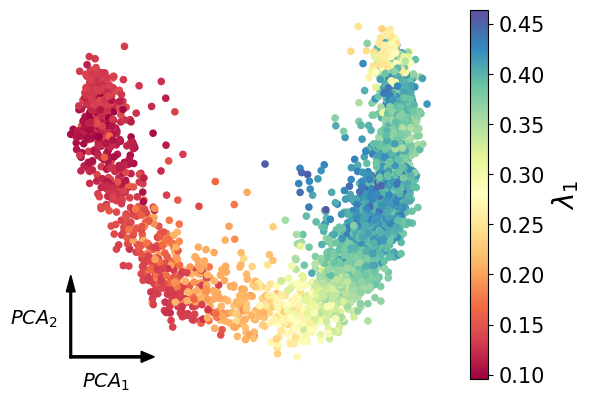

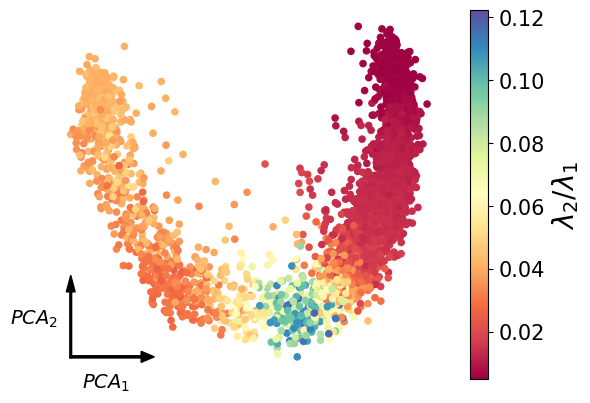

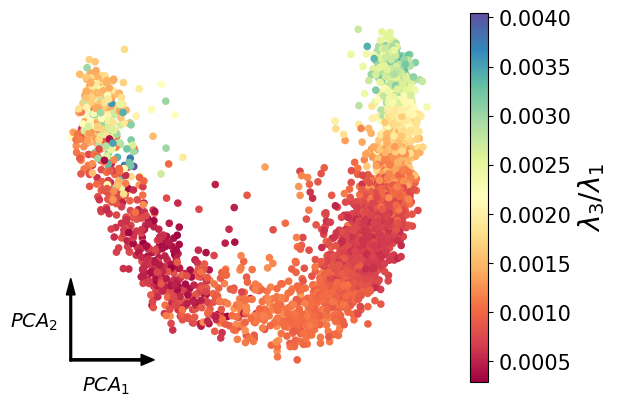

In [48]:
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs_eg[:,0]), cmap=cmap, s=20)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel(f'$\lambda_{1}$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+f'eig_eigen_{1}')
plt.show()

for k in range(1,eigen_dim):
    cmap = plt.colormaps['Spectral']
    plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs_eg[:,k]/eigs_eg[:,0]), cmap=cmap, s=20)
    plt.axis('off')

    clb=plt.colorbar()
    clb.ax.set_ylabel(f'$\lambda_{k+1}/\lambda_{1}$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)

    plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
    plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
    plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
    plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

    plt.savefig(result_path+f'eig_ratio_eigen_{k+1}')
    plt.show()

In [49]:
np.save(result_path+'/fisher_eigen', Fisher_eg)
np.save(result_path+'/eig_eigen', eigs_eg)
np.save(result_path+'/eigvec_eigen', eigvecs_eg)

## **Fisher hotspot**

In [50]:
import hotspot

In [51]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
hs = hotspot.Hotspot(
    adata, 
    model='danb',
    distances_obsp_key = 'distances'
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [52]:
hs_results = hs.compute_autocorrelations(jobs=1)

hs_results.head(15)

100%|██████████| 678/678 [00:00<00:00, 756.35it/s] 


C           Z  Pval  FDR
Gene                                          
Fabp7          0.844943  127.798696   0.0  0.0
Dbi            0.823025  117.594362   0.0  0.0
Slc1a3         0.813121  113.347819   0.0  0.0
Calb2          0.749221  113.065157   0.0  0.0
Ptn            0.785283  110.143898   0.0  0.0
Hmgb2          0.774798  101.521338   0.0  0.0
2810417H13Rik  0.772363   98.486233   0.0  0.0
Calb1          0.743785   97.186069   0.0  0.0
Eomes          0.623338   90.545989   0.0  0.0
Pbk            0.706040   87.553895   0.0  0.0
Top2a          0.674373   87.087081   0.0  0.0
Tubb3          0.781674   81.486989   0.0  0.0
Ttc28          0.715343   80.097509   0.0  0.0
Cdc20          0.606238   79.302838   0.0  0.0
Nrgn           0.718547   78.960729   0.0  0.0

In [53]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(800).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

Computing pair-wise local correlation on 670 features...


100%|██████████| 224115/224115 [00:17<00:00, 12823.23it/s]


**Tuning parameter: min_gene_threshold**

In [54]:
modules = hs.create_modules(
    min_gene_threshold=100, core_only=True, fdr_threshold=0.05
)

modules.value_counts()
# np.save(result_path+'modules', modules.values)
# np.save(result_path+'hs_genes', hs_genes)

Module
 3    264
 2    199
 1    198
-1      9
Name: count, dtype: int64

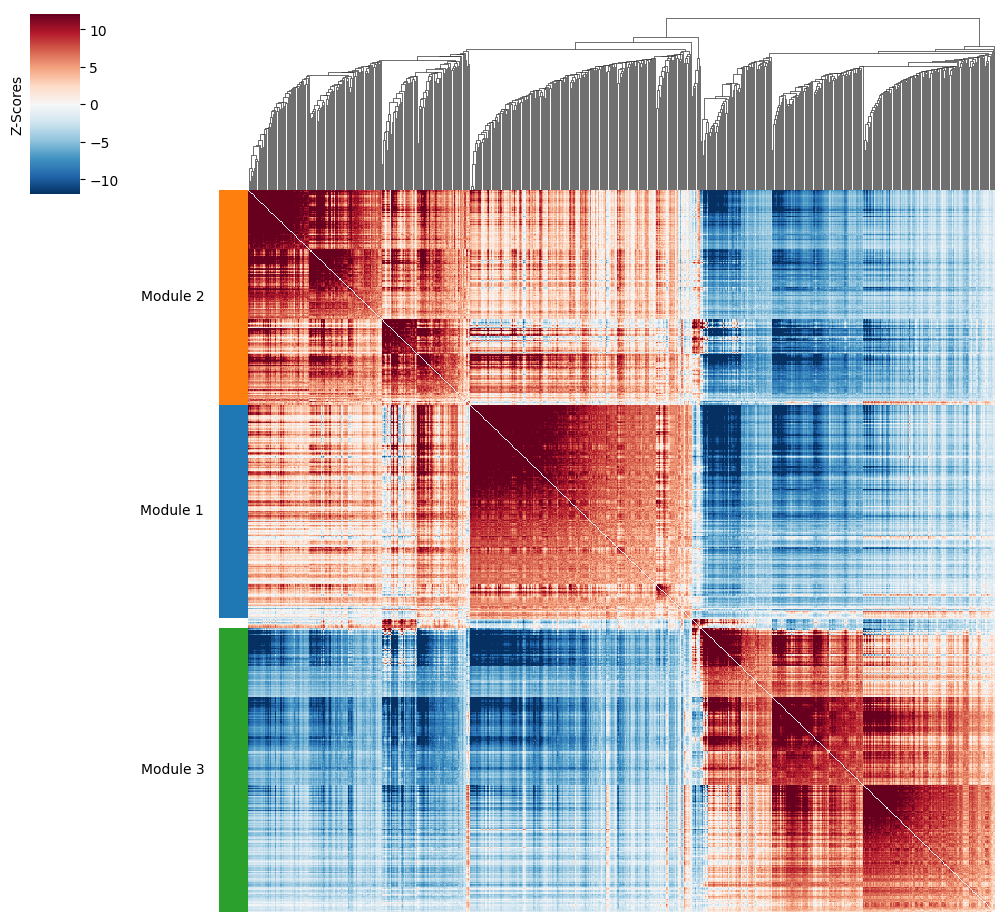

In [55]:
hs.plot_local_correlations(vmin=-12, vmax=12)

In [56]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 3 modules...


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


1         2         3
10X84_2:AAATGCCAGGTGCTAGx  12.915703 -1.026304 -5.686422
10X84_2:AAACCTGAGTTGAGTAx  -1.379752 -0.417914 -1.675692
10X84_2:AACACGTGTTATCGGTx  -2.432012 -1.883523  1.202189
10X84_2:AAAGTAGAGCTCAACTx  -2.732021 -3.092725  5.595967
10X84_2:AAACCTGTCCTTTACAx  -2.281077 -2.013199  1.369193

In [57]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

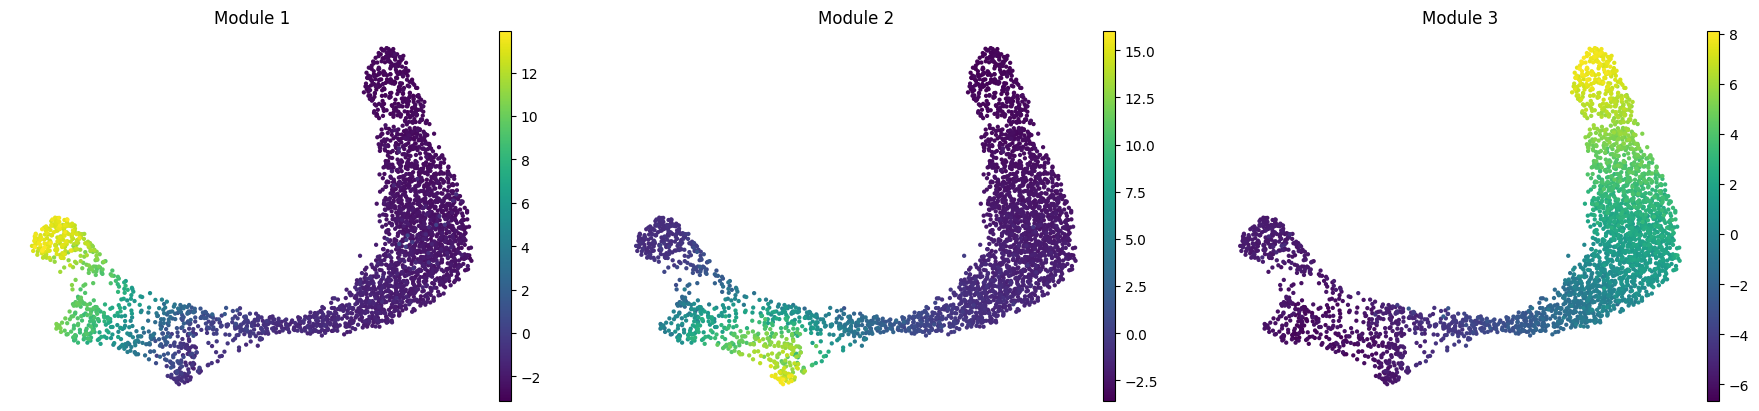

In [58]:
fig = sc.pl.umap(adata, color=module_cols, frameon=False, return_fig=True)

In [59]:
adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module
adata_hs.var_names

Index(['Fabp7', 'Dbi', 'Slc1a3', 'Calb2', 'Ptn', 'Hmgb2', '2810417H13Rik',
       'Calb1', 'Eomes', 'Pbk',
       ...
       'Arhgap44', 'Trpc1', 'Coro2a', 'Cacnb2', 'Ptprr', 'Iqgap3', 'Riiad1',
       'Aldh6a1', 'Adgra1', 'Gab1'],
      dtype='object', length=670)

In [60]:
scaler = StandardScaler()
X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
hs_X_w = eigen_gene(X_hs,T_hs)
hs_dim=len(hs_X_w)
print(hs_dim)

[0.4927525  0.05807352]
[0.46228793 0.11247507]
[0.42976987 0.13717869]
3


In [61]:
cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
for j in range(X_hs.shape[0]):
    for k in range(len(hs_X_w)):
        cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])

In [62]:
model = nn.Sequential(
    nn.Linear(cell_hs_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

x_in=torch.tensor(cell_hs_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_phs = np.zeros([cell_hs_X.shape[0], L*2, cell_hs_X.shape[1]])

# Compute the gradients
for i in range(cell_hs_X.shape[0]):
    x0=torch.tensor(cell_hs_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_phs[i,j,:] = x0.grad.detach()
print(pZ_phs.shape)

(3139, 20, 3)


In [63]:
Fisher_hs = np.zeros((X.shape[0],hs_dim, hs_dim))
for i in range(X.shape[0]):
    Fisher_hs[i] = pZ_phs[i].T@Fisher_g[i]@pZ_phs[i]

In [64]:
eigs_hs = np.zeros((X.shape[0],hs_dim))
eigvecs_hs = np.zeros((X.shape[0],hs_dim, hs_dim))
for i in range(X.shape[0]):
    eig, eigvec = np.linalg.eig(Fisher_hs[i])
    sorted_indices = np.argsort(eig)[::-1]  # 从大到小排序
    eigs_hs[i] = eig[sorted_indices]
    eigvecs_hs[i] = eigvec[sorted_indices]

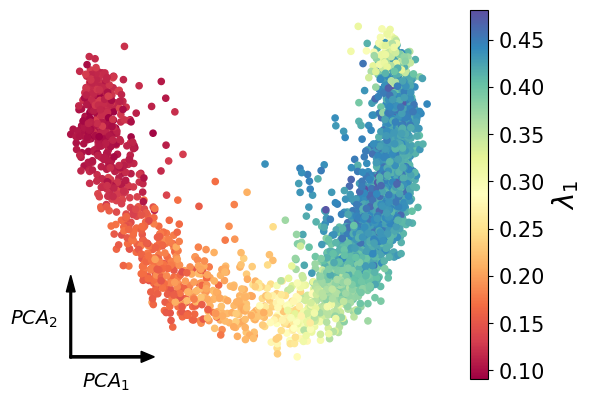

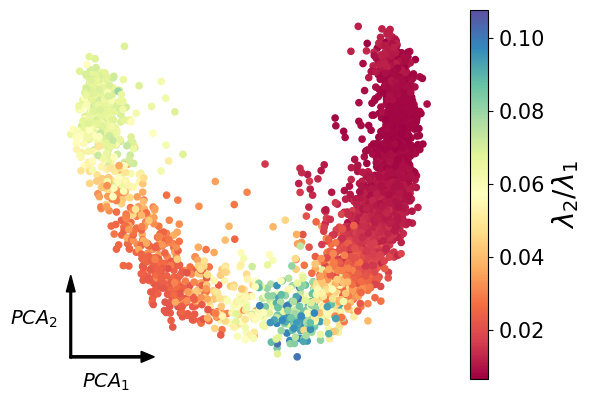

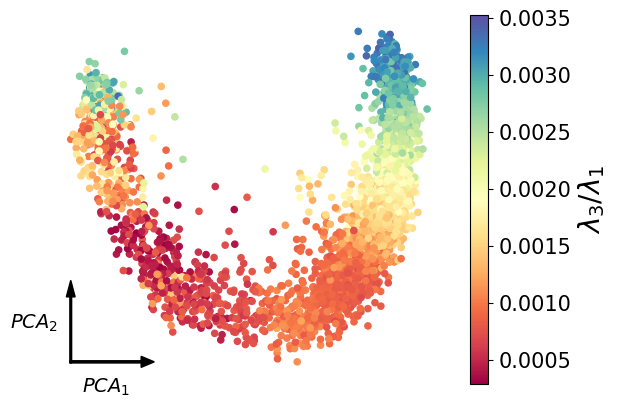

In [65]:
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs_hs[:,0]), cmap=cmap, s=20)
plt.axis('off')

clb=plt.colorbar()
clb.ax.set_ylabel(f'$\lambda_{1}$',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

plt.savefig(result_path+f'eig_hotspot_{1}')
plt.show()

for k in range(1,hs_dim):
    cmap = plt.colormaps['Spectral']
    plt.scatter(X_plt[idx],Y_plt[idx], c=smooth_func(eigs_hs[:,k]/eigs_hs[:,0]), cmap=cmap, s=20)
    plt.axis('off')

    clb=plt.colorbar()
    clb.ax.set_ylabel(f'$\lambda_{k+1}/\lambda_{1}$',fontsize=20,weight='bold')
    clb.ax.tick_params(axis='y', labelsize=15)

    plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
    plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
    plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
    plt.text(X_ori-wid*21,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

    plt.savefig(result_path+f'eig_ratio_hotspot_{k+1}')
    plt.show()

In [66]:
np.save(result_path+'/fisher_hotspot', Fisher_hs)
np.save(result_path+'/eig_hotspot', eigs_hs)
np.save(result_path+'/eigvec_hotspot', eigvecs_hs)
np.save(result_path+'/cell_hs_X', cell_hs_X )
np.save(result_path+'/cell_eigen_X', cell_eigen_X)